In [1]:
using Plots,SparseArrays,Arpack

2×4 Matrix{Int64}:
 251  751  251  751
 251  251  751  751

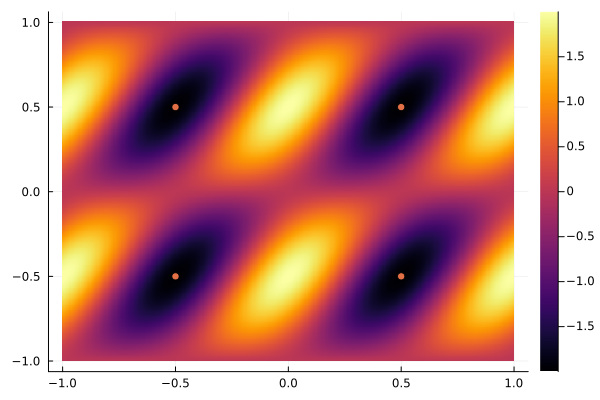

In [23]:
r = -1.0
V(x,y) = cos(2π*x)+r*cos(2π*(y-x))
N = 1000

X = collect(range(-1,1,N+1))
pop!(X)


@inline ind(i,j) = N*i+j
@inline prev(i) = mod(i-1,1:N)
@inline next(i) = mod(i+1,1:N)

neighbors(i,j) = [[i,prev(j)],[i,next(j)],[prev(i),j],[next(i),j]]

minima = [[i,j] for i=1:N, j=1:N if V(X[i],X[j]) < minimum(V(X[n]...) for n in neighbors(i,j))]
minima=hcat(minima...)
display(minima)

disprange = range(-1,1,400)
heatmap(disprange,disprange,V)
scatter!(X[minima[1,:]],X[minima[2,:]],label="")


In [ ]:
function eigenproblem(β,V,xlims,ylims,N,Ω)
    Ω(tup) = Ω(tup...)

    xmin,xmax=xlims
    ymin,ymax=ylims

    xrange = collect(range(xmin,xmax,N+1))
    yrange = collect(range(ymin,ymax,N+1))

    pop!(xrange)
    pop!(yrange)

    X = collect([(x,y) for x=xrange,y=yrange])

    to_seq(i,j) = N*(j-1)+ i
    to_seq(tup) = to_seq(tup...)
    to_coord(ix) = begin q,r = divrem(ix,N) ; return (q+1,(r==0) ? N:r) end
    neighbors(ix) = begin i,j = to_coord(ix) ; return to_seq.([(i,mod(j-1,1:N)),(i,mod(j+11,1:N)),(mod(i-1,1:N),j),(mod(i+1,1:N),j)]) end

    rate(i,j) = exp(-β*(V(X[j]...)-V(X[i]...))/2)
    rate_witten(i,j) = exp(-β*(V(X[j]...)-V(X[i]...)))
    rows = vcat(([i for j=neighbors(i)] for i=1:N)...)
    cols = vcat(([i,prev(i),next(i)] for i=1:N)...)

    fac = N^2/β # scaling constant -- for consistent approximation of -L = ∇V⋅∇ - β⁻¹Δ
    
    vals = Float64[]
    rows = Int64[]
    cols = Int64[]
        
    for ix=1:N^2
        ns = neighbors(ix)
        rs = -rates(ix)
        
        append!(vals,[-sum(rs),rs...])
        append!(rows,fill(ix,length(ns)+1))
        append!(cols,[ix,ns...])

        rates(ix) = [rate(ix,n) for n = neighbors(ix)]
    end

    Ωind = collect(1:N^2)[Ω.(X)]

    L = sparse(rows,cols,vals)

    λs,us = eigs(L[Ωind,Ωind],sigma=0,nev=3,which=:LR,tol=1e-22)

    λs = real.(λs)
    us = real.(us)

    return λs[1],λs[2],us[:,1],us[:,2],L
end